## Connecting with Google drive

In [1]:
from google.colab import drive

drive.mount('/content/drive')
#root_path = 'drive/My Drive/Lab/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Select current working directory or folder

In [2]:
import os
print("Current working directory: "+os.getcwd())
default_path = '/content/drive/My Drive/Lab/API'
os.chdir(default_path)
print("Current working directory: "+os.getcwd())

Current working directory: /content
Current working directory: /content/drive/My Drive/Lab/API


## Import Support files and packages

In [3]:
from utils import *
# from image_transform import ImageTransform
from loader import Loader
from graph_plot import *
from test import TestModel
from train import TrainModel
from display_images import *
from train_network import *
# from cutout import Cutout
from albumentation_transform import AlbumentationTransformations


# from resnet import *
# from albumentations.augmentations.transforms import RandomSizedCrop
from albumentations import *
from albumentations.pytorch.transforms import ToTensor

In [4]:
IMAGE_PATH = "/content/drive/My Drive/Lab/s11/"
PATH = "/content/drive/My Drive/Lab/s11"
MODEL_PATH = "/content/drive/My Drive/Lab/s11/"

train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

## Setup device

In [5]:
# Device
SEED = 1
cuda = torch.cuda.is_available()
print("Cuda is available ?", cuda)
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)
device = torch.device("cuda" if cuda else "cpu")

Cuda is available ? True


## Load DevidNet model

In [6]:
from devidnet_architecture import resnet20
model = resnet20().to(device)

## Model Summary (Layers and Parameter)

In [7]:
summary(model, input_size=(3, 32, 32))
model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]          73,728
       BatchNorm2d-5          [-1, 128, 16, 16]             256
              ReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]         147,456
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
           Conv2d-12          [-1, 128, 16, 16]           8,192
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14          [-1, 128,

Cifar10ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): C

## Data augmentation, Dataset, DataLoader

In [8]:
img_mean = (0.4914, 0.4822, 0.4465)
img_std = (0.2023, 0.1994, 0.2010)

# Transforms
means = np.array(img_mean)
stdevs = np.array(img_std)
patch_size = 32



# Define Train transforms and Test transforms

transform_train = [
                   
                   PadIfNeeded(38,38),                   
                   RandomSizedCrop((patch_size,patch_size), patch_size,patch_size),      
    #  RandomSizedCrop(always_apply=False, p=1.0, min_max_height=(24, 28), height=32, width=32, w2h_ratio=1.0, interpolation=0),
      Cutout(8,8),
      
      HorizontalFlip(p = 0.5),
      # MotionBlur(),   
      Normalize(mean=means, std=stdevs),
      ToTensor()
    ]

transform_test = [Normalize(mean=means, std=stdevs),
      ToTensor()
    ]

# Create Train transforms and Test transforms
t_transform_train =  AlbumentationTransformations(transform_train)
t_transform_test = AlbumentationTransformations(transform_test)
# transform_train = [  
#                    transforms.RandomHorizontalFlip(),
#                    transforms.RandomCrop(32, padding=4),          
#                    transforms.ToTensor(),
#                    transforms.Normalize(mean=means, std=stdevs),
#                    Cutout(1,16),    
#     ]

# transform_test = [transforms.ToTensor(),
#                   transforms.Normalize(mean=means, std=stdevs),
         
#     ]

# # Create Train transforms and Test transforms
# t_transform_train =  ImageTransform.transform(transform_train)
# t_transform_test = ImageTransform.transform(transform_test)

# Dataset and DataLoader arguments
dataset_name = torchvision.datasets.CIFAR10
trainSet_dict = dict(root='./data', train=True, download=True, transform=t_transform_train)
trainLoad_dict = dict(batch_size=512, shuffle=True, num_workers=4)
testSet_dict = dict(root='./data', train=False, download=True, transform=t_transform_test)
testLoad_dict = dict(batch_size=32, shuffle=False, num_workers=4)


# Create Train Loader and Test Loader
trainloader = Loader.getDataLoader(dataset_name, trainSet_dict, trainLoad_dict)
testloader = Loader.getDataLoader(dataset_name, testSet_dict, testLoad_dict)
classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Loss Function, Optimizer and LR Scheduler

In [9]:
# model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=.4, weight_decay=1e-2)
scheduler =torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

## Best Learning Rate Finder

########## Leslie Smith's approach ###########



Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.61E-01


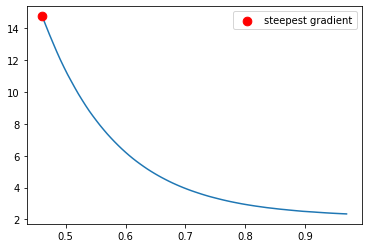

In [10]:
from find_lr_max import *
lrMax = get_LR(model, trainloader, optimizer, criterion, device)

## Hyperparameters

In [11]:
lrMax

0.46060606060606063

In [12]:
# import pdb
# pdb.set_trace()

In [13]:
# Hyper parameters
LAMBDA1 = 1e-5
LR =  lrMax
MOMENTUM = (0.95, 0.85)
WEIGHT_DECAY = .0001   #
Max_EPOCHS = 29
LR_EPOCHS = 5
DIV_FACTOR = 25.0 #18.0
START_PERCENT = 0.5 #LR_EPOCHS/Max_EPOCHS  #0.5#0.125

## Train network for few epochs to find best learning rate and save the model

In [14]:
lr_list, moms_list, train_losses, train_accuracy, test_losses, test_accuracy, optimizer = trainNetwork(model,device, trainloader, testloader, optimizer, criterion, epochs=5, lr_max=LR, moms=MOMENTUM, div_factor=DIV_FACTOR, pct_start=START_PERCENT,
                 MODEL_PATH=MODEL_PATH, L1_regularization=None)

: EPOCH= 0 Loss= 2.3157 Batch_id= 97 Accuracy= 11.76: 100%|██████████| 98/98 [00:24<00:00,  3.94it/s]



Test set: Average Loss= 0.0721 Batch_id= 312 Accuracy= 1218/10000 (12.18%)



: EPOCH= 1 Loss= 2.1709 Batch_id= 97 Accuracy= 15.55: 100%|██████████| 98/98 [00:25<00:00,  3.88it/s]



Test set: Average Loss= 0.0667 Batch_id= 312 Accuracy= 2072/10000 (20.72%)



: EPOCH= 2 Loss= 1.9219 Batch_id= 97 Accuracy= 23.75: 100%|██████████| 98/98 [00:24<00:00,  3.93it/s]



Test set: Average Loss= 0.0633 Batch_id= 312 Accuracy= 2345/10000 (23.45%)



: EPOCH= 3 Loss= 1.8447 Batch_id= 97 Accuracy= 31.55: 100%|██████████| 98/98 [00:25<00:00,  3.92it/s]



Test set: Average Loss= 0.0583 Batch_id= 312 Accuracy= 3162/10000 (31.62%)



: EPOCH= 4 Loss= 1.5637 Batch_id= 97 Accuracy= 37.72: 100%|██████████| 98/98 [00:25<00:00,  3.92it/s]



Test set: Average Loss= 0.0537 Batch_id= 312 Accuracy= 3623/10000 (36.23%)



## Plot learning rate cycle scheduler

In [15]:
# from cyclic_learning_rate import *
# lr_min, lr_max, step_size, max_iteration, path, name = 0.08, 0.8, 10, 100, PATH+"/visualization", "clr_graph"
# generate_cyclic_learning_rate(lr_min, lr_max, step_size, max_iteration, path, name)

In [16]:
PATH = "/content/drive/My Drive/Lab/s11"

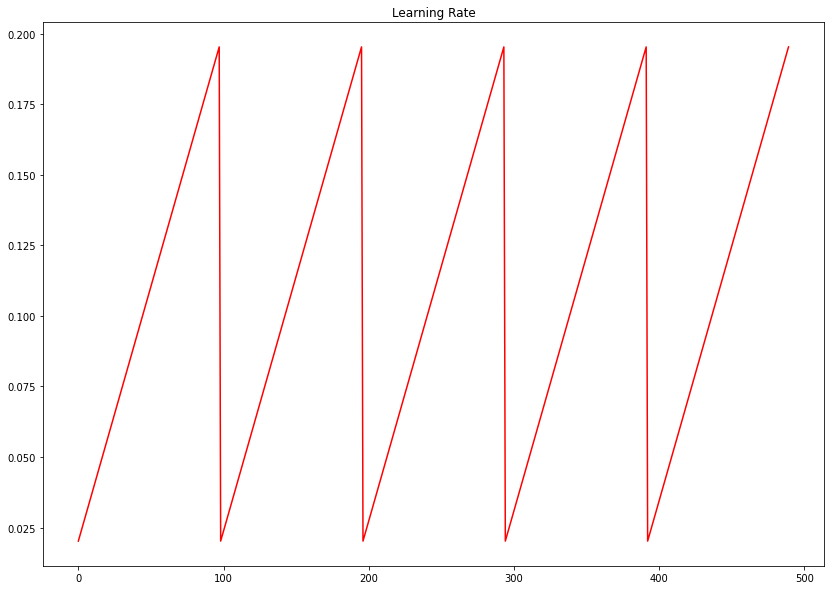

In [17]:
from graph_plot import *
plot_lr(lr_list,name="lr_plot", PATH=PATH+str("/visualization/"))

## Load model

In [18]:
filename = MODEL_PATH + "S11_model.pth"

In [19]:
def load_checkpoint(model, optimizer,  filename='checkpoint.pth.tar'):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        # losslogger = checkpoint['losslogger']
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch

In [20]:
#model = ResNet18().to(device)
model, optimizer, start_epoch = load_checkpoint(model, optimizer,  filename)

=> loading checkpoint '/content/drive/My Drive/Lab/s11/S11_model.pth'
=> loaded checkpoint '/content/drive/My Drive/Lab/s11/S11_model.pth' (epoch 5)


In [21]:
optimizer.param_groups[-1]["lr"] = optimizer.param_groups[-1]["lr"]/10
# optimizer.param_groups[-1]["weight_decay"] = 1e-3

# Training  network

In [22]:
# Train more
for epoch in range(start_epoch, Max_EPOCHS):
  train_loss, train_acc = TrainModel.train(model, device, trainloader, criterion, optimizer, epoch)
  # scheduler.step()
  train_losses.append(train_loss)
  train_accuracy.append(train_acc)
  test_loss, test_acc = TestModel.test(model, device, testloader, criterion)
  # scheduler.step(test_loss)
  test_losses.append(test_loss)
  test_accuracy.append(test_acc)

  state = {'epoch': epoch + 1, 'state_dict': model.state_dict(),
             'optimizer': optimizer.state_dict()}
  torch.save(state, filename)

: EPOCH= 5 Loss= 1.4663 Batch_id= 97 Accuracy= 43.70: 100%|██████████| 98/98 [00:24<00:00,  3.96it/s]



Test set: Average Loss= 0.0438 Batch_id= 312 Accuracy= 4920/10000 (49.20%)



: EPOCH= 6 Loss= 1.4625 Batch_id= 97 Accuracy= 46.51: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]



Test set: Average Loss= 0.0419 Batch_id= 312 Accuracy= 5095/10000 (50.95%)



: EPOCH= 7 Loss= 1.3343 Batch_id= 97 Accuracy= 48.78: 100%|██████████| 98/98 [00:24<00:00,  3.92it/s]



Test set: Average Loss= 0.0401 Batch_id= 312 Accuracy= 5307/10000 (53.07%)



: EPOCH= 8 Loss= 1.2984 Batch_id= 97 Accuracy= 51.07: 100%|██████████| 98/98 [00:24<00:00,  3.92it/s]



Test set: Average Loss= 0.0385 Batch_id= 312 Accuracy= 5489/10000 (54.89%)



: EPOCH= 9 Loss= 1.2006 Batch_id= 97 Accuracy= 53.21: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]



Test set: Average Loss= 0.0376 Batch_id= 312 Accuracy= 5621/10000 (56.21%)



: EPOCH= 10 Loss= 1.2122 Batch_id= 97 Accuracy= 56.03: 100%|██████████| 98/98 [00:25<00:00,  3.92it/s]



Test set: Average Loss= 0.0354 Batch_id= 312 Accuracy= 5847/10000 (58.47%)



: EPOCH= 11 Loss= 1.0992 Batch_id= 97 Accuracy= 58.85: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]



Test set: Average Loss= 0.0326 Batch_id= 312 Accuracy= 6284/10000 (62.84%)



: EPOCH= 12 Loss= 0.9695 Batch_id= 97 Accuracy= 60.94: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]



Test set: Average Loss= 0.0298 Batch_id= 312 Accuracy= 6600/10000 (66.00%)



: EPOCH= 13 Loss= 0.9797 Batch_id= 97 Accuracy= 63.34: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]



Test set: Average Loss= 0.0299 Batch_id= 312 Accuracy= 6594/10000 (65.94%)



: EPOCH= 14 Loss= 0.9152 Batch_id= 97 Accuracy= 65.01: 100%|██████████| 98/98 [00:25<00:00,  3.87it/s]



Test set: Average Loss= 0.0282 Batch_id= 312 Accuracy= 6760/10000 (67.60%)



: EPOCH= 15 Loss= 0.9199 Batch_id= 97 Accuracy= 67.25: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]



Test set: Average Loss= 0.0272 Batch_id= 312 Accuracy= 6926/10000 (69.26%)



: EPOCH= 16 Loss= 0.9292 Batch_id= 97 Accuracy= 69.00: 100%|██████████| 98/98 [00:25<00:00,  3.78it/s]



Test set: Average Loss= 0.0245 Batch_id= 312 Accuracy= 7242/10000 (72.42%)



: EPOCH= 17 Loss= 0.7259 Batch_id= 97 Accuracy= 70.06: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]



Test set: Average Loss= 0.0233 Batch_id= 312 Accuracy= 7406/10000 (74.06%)



: EPOCH= 18 Loss= 0.7977 Batch_id= 97 Accuracy= 71.31: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]



Test set: Average Loss= 0.0224 Batch_id= 312 Accuracy= 7460/10000 (74.60%)



: EPOCH= 19 Loss= 0.7428 Batch_id= 97 Accuracy= 72.82: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]



Test set: Average Loss= 0.0233 Batch_id= 312 Accuracy= 7438/10000 (74.38%)



: EPOCH= 20 Loss= 0.7669 Batch_id= 97 Accuracy= 74.09: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]



Test set: Average Loss= 0.0195 Batch_id= 312 Accuracy= 7790/10000 (77.90%)



: EPOCH= 21 Loss= 0.6826 Batch_id= 97 Accuracy= 75.36: 100%|██████████| 98/98 [00:25<00:00,  3.78it/s]



Test set: Average Loss= 0.0198 Batch_id= 312 Accuracy= 7802/10000 (78.02%)



: EPOCH= 22 Loss= 0.7196 Batch_id= 97 Accuracy= 76.22: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]



Test set: Average Loss= 0.0181 Batch_id= 312 Accuracy= 7928/10000 (79.28%)



: EPOCH= 23 Loss= 0.5787 Batch_id= 97 Accuracy= 77.62: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]



Test set: Average Loss= 0.0170 Batch_id= 312 Accuracy= 8092/10000 (80.92%)



: EPOCH= 24 Loss= 0.6652 Batch_id= 97 Accuracy= 78.71: 100%|██████████| 98/98 [00:25<00:00,  3.77it/s]



Test set: Average Loss= 0.0167 Batch_id= 312 Accuracy= 8156/10000 (81.56%)



: EPOCH= 25 Loss= 0.5542 Batch_id= 97 Accuracy= 79.16: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]



Test set: Average Loss= 0.0183 Batch_id= 312 Accuracy= 7964/10000 (79.64%)



: EPOCH= 26 Loss= 0.6539 Batch_id= 97 Accuracy= 79.90: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]



Test set: Average Loss= 0.0151 Batch_id= 312 Accuracy= 8343/10000 (83.43%)



: EPOCH= 27 Loss= 0.5354 Batch_id= 97 Accuracy= 81.04: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]



Test set: Average Loss= 0.0152 Batch_id= 312 Accuracy= 8300/10000 (83.00%)



: EPOCH= 28 Loss= 0.6511 Batch_id= 97 Accuracy= 81.34: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]



Test set: Average Loss= 0.0161 Batch_id= 312 Accuracy= 8208/10000 (82.08%)



## Show and Save losses and accuracy Plot

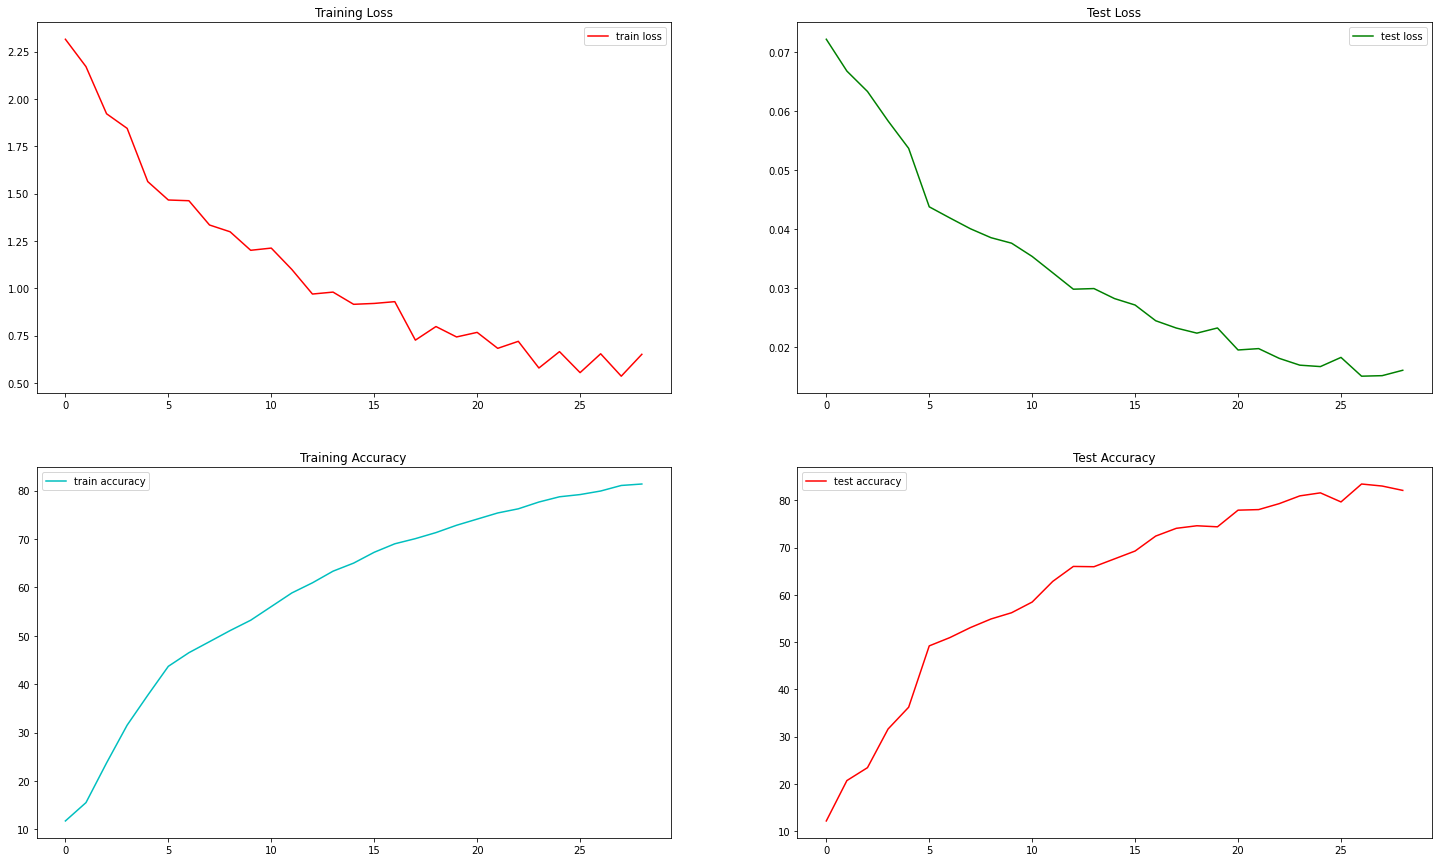

In [23]:
getPlottedGraph(Max_EPOCHS, train_losses, train_accuracy, test_losses, test_accuracy,name="S11_plot", PATH=PATH+str("/visualization/"))

## Load Model

In [35]:
def load_checkpoint(model, optimizer,  filename='checkpoint.pth.tar'):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        # losslogger = checkpoint['losslogger']
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch

In [37]:
model = resnet20().to(device)
model, optimizer, start_epoch = load_checkpoint(model, optimizer,  filename)

=> loading checkpoint '/content/drive/My Drive/Lab/s11/S11_model.pth'
=> loaded checkpoint '/content/drive/My Drive/Lab/s11/S11_model.pth' (epoch 29)


## Show and Save correct classified images

/content/drive/My Drive/Lab/API/display_images.py:134: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  misclassified_imgs_indexes = (pred.eq(target.view_as(pred)) == False).nonzero()[:, 0]


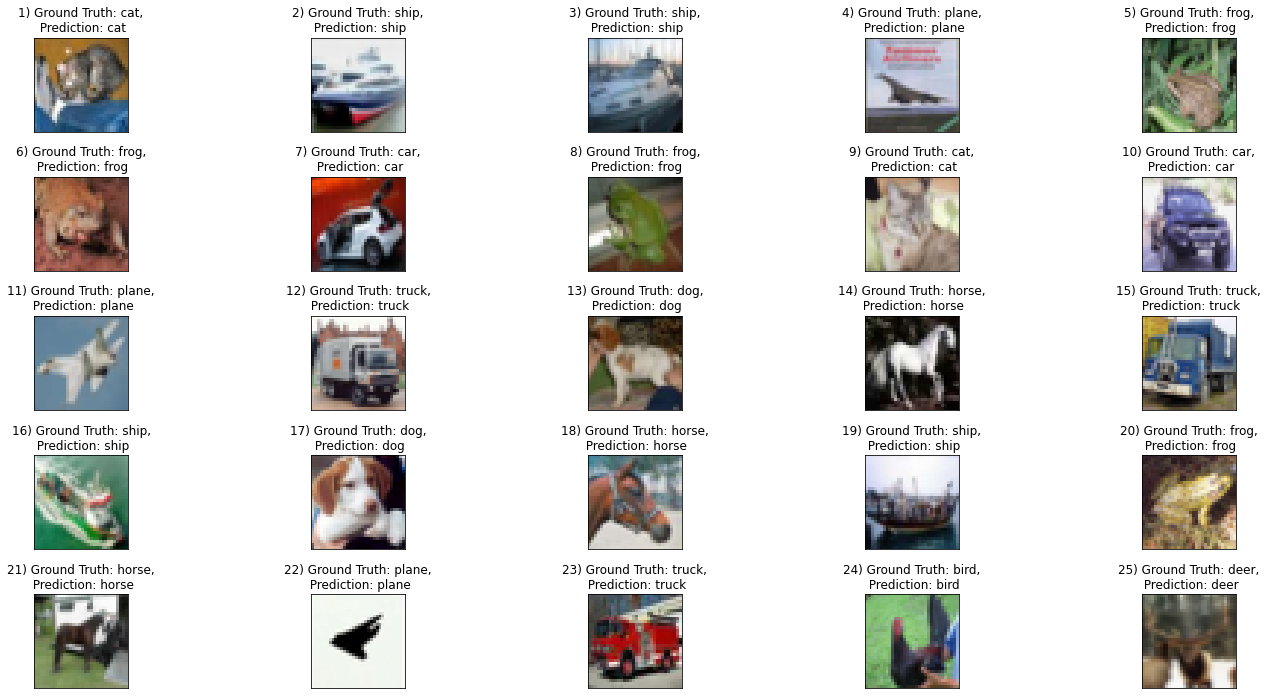

In [38]:
show_save_correctly_classified_images(model, testloader, device, PATH, name="correct_classified_imgs", max_correctly_classified_images_imgs=25,labels_list=classes)

## Show and Save misclassified images

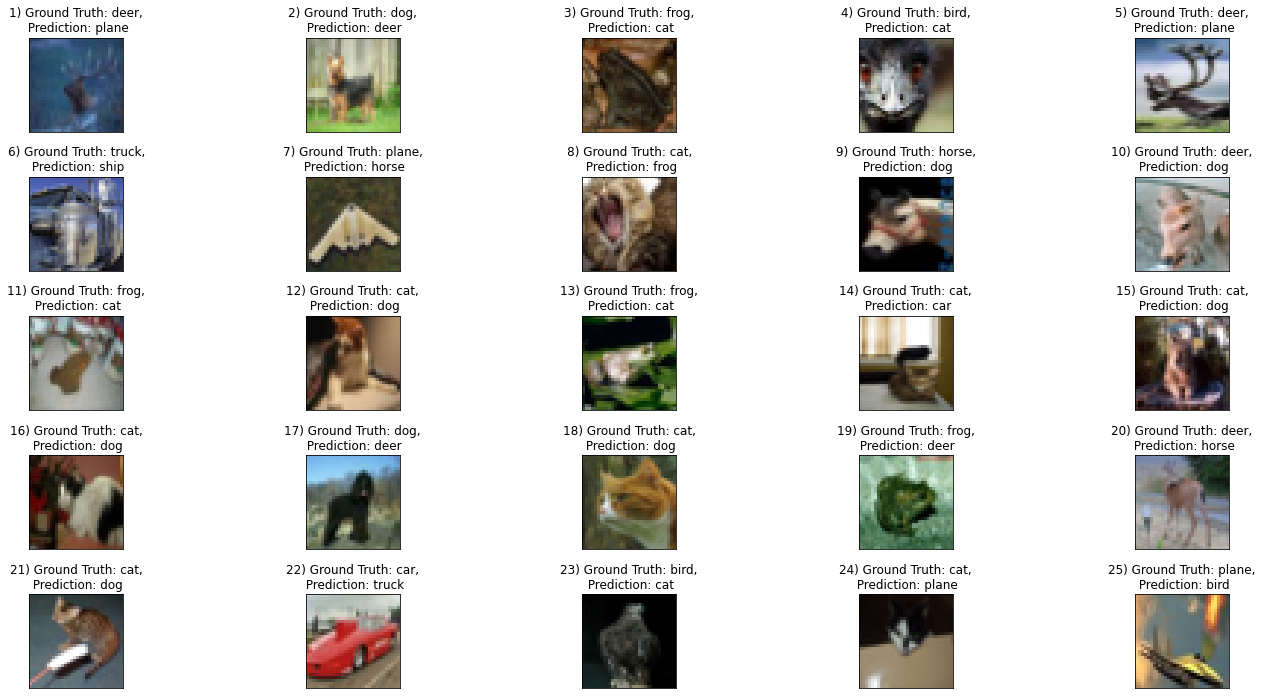

In [39]:
show_save_misclassified_images(model, testloader, device, PATH, name="misclassified_imgs", max_misclassified_imgs=25,labels_list=classes)

## Grad Cam

### Top 5 Correct classified image GradCam 

In [40]:
misclassified_imgs, correctly_classified_images = classify_images(model, testloader, device, 25)

In [41]:
from grad_cam import *

In [42]:
layers_list = ["layer1","layer2","layer3"]
display_gradcam = VisualizeCam(model, classes, layers_list)

### Top 5 misclassifeid image GradCam 

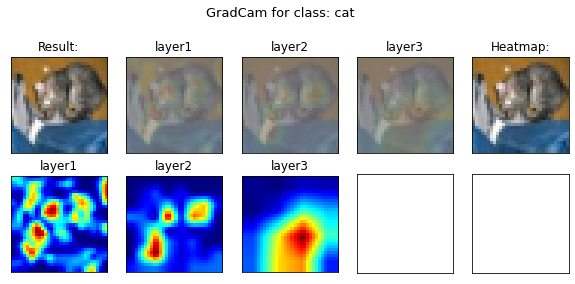

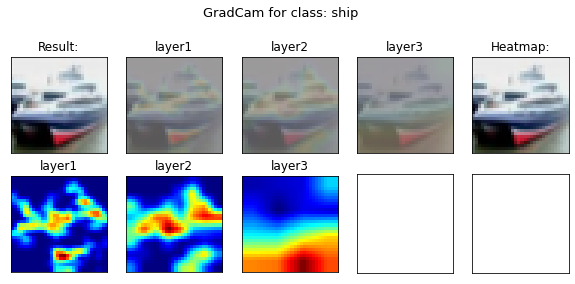

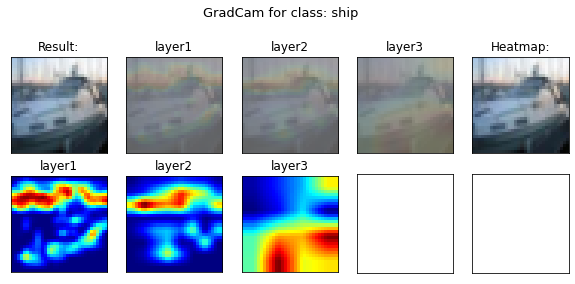

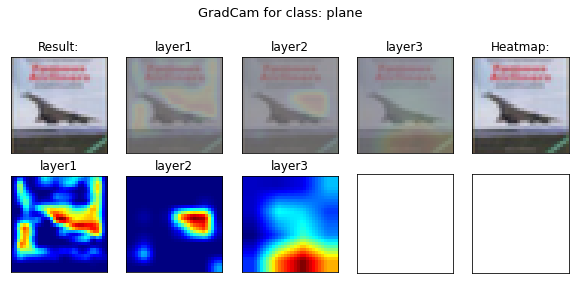

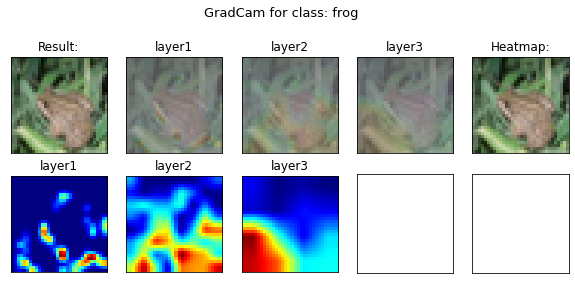

In [43]:
correct_pred_imgs = []
for i in range(len(correctly_classified_images)):
  correct_pred_imgs.append(torch.as_tensor(correctly_classified_images[i]["img"]))
display_gradcam(torch.stack(correct_pred_imgs), layers_list, PATH+str("/visualization"), metric="correct")

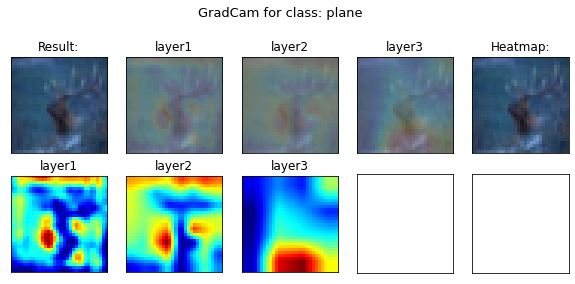

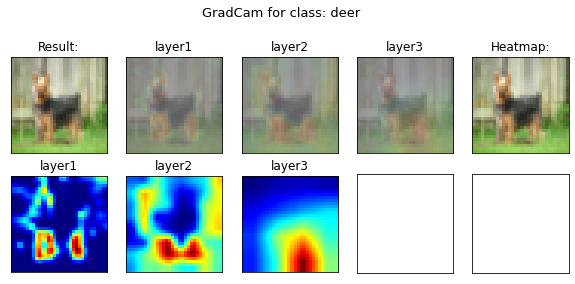

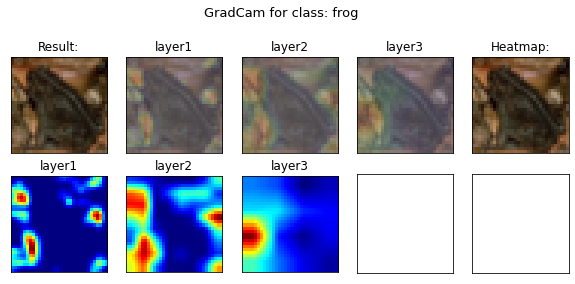

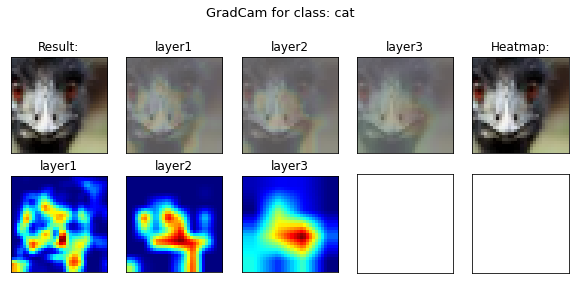

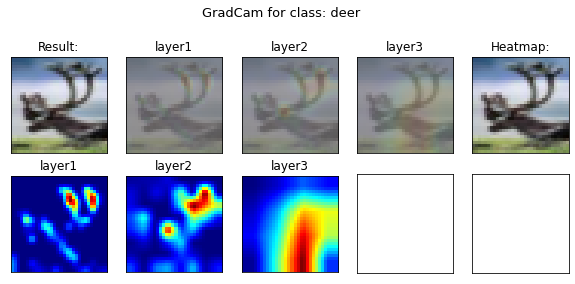

In [44]:
misclassify_pred_imgs = []
for i in range(len(misclassified_imgs)):
  misclassify_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
display_gradcam(torch.stack(misclassify_pred_imgs), layers_list, PATH+str("/visualization"), metric="misclassify")

### 25 misclassified images GradCam

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

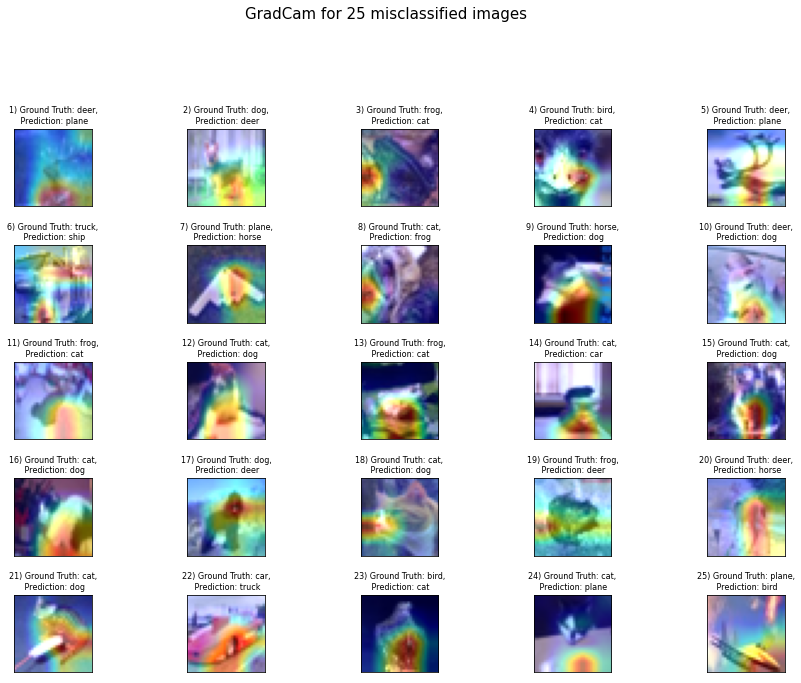

In [45]:
display_gradcam.plot_img_heatmap(misclassified_imgs, layers_list, PATH+"/visualization", target_inds=None, metric="", name="gradcam_misclassified_images")

In [34]:
# # Train more
# for epoch in range(start_epoch, start_epoch+2):
#   train_loss, train_acc = TrainModel.train(model, device, trainloader, criterion, optimizer, epoch)
#   # scheduler.step()
#   train_losses.append(train_loss)
#   train_accuracy.append(train_acc)
#   test_loss, test_acc = TestModel.test(model, device, testloader, criterion)
#   test_losses.append(test_loss)
#   test_accuracy.append(test_acc)

#   state = {'epoch': epoch + 1, 'state_dict': model.state_dict(),
#              'optimizer': optimizer.state_dict()}
#   torch.save(state, filename)